# Modelo de recomendación de recetas

### Librerías necesarias

In [129]:
# Para manipulacion de datos
import ast
import numpy as np
import pandas as pd

# Para preparar datos
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Para la construccion del modelo
from keras.layers import Dense, Embedding, Flatten 
from keras.models import Sequential

# Para la evaluacion del modelo
import matplotlib.pyplot as plt


### Data inicial

In [113]:
recipes = pd.read_csv("data/RAW_recipes.csv")
recipes['ingredients'] = recipes['ingredients'].apply(ast.literal_eval)
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8


### Preparación de datos

In [114]:

ingredients = ['apple', 'banana', 'orange', 'tomato', 'carrot', 'bread', 'cheese', 'mango', 'broccoli', 'grape', 'lemmon', 'pineapple']

# Filtrando las recetas que contengan al menos 1 ingredieente de la lista o mas
recipes = recipes[recipes['ingredients'].apply(lambda x: any([k in x for k in ingredients]))]
len(recipes)

18122

In [115]:
# Filtrando receptas que contengan 20 ingredientes o menos
max_len = 20
recipes = recipes[recipes['ingredients'].apply(lambda x: all(len(i) <= max_len for i in x))]
len(recipes)

11191

In [116]:
recipes.to_csv('recipes.csv', index=False)


In [117]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
16,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"[egg roll wrap, whole green chilies, cheese, c...",5
23,deep fried dessert thingys,107699,20,158966,2005-01-05,"['30-minutes-or-less', 'time-to-make', 'course...","[1663.3, 221.0, 168.0, 66.0, 19.0, 158.0, 29.0]",20,"['in a large bowl , mix flour , granulated sug...",my mother used to make this for us as a specia...,"[all-purpose flour, granulated sugar, baking p...",13
63,more more apple pear jigglers,63593,125,47858,2003-06-02,"['weeknight', 'time-to-make', 'main-ingredient...","[22.9, 1.0, 5.0, 0.0, 1.0, 3.0, 0.0]",6,"['in a food processor or blender , process the...",it's a fun finger food for infants and toddler...,"[unflavored gelatin, milk, cream cheese, yogur...",6
66,my muffuletta sandwich,78655,20,12875,2003-12-12,"['30-minutes-or-less', 'time-to-make', 'course...","[181.1, 26.0, 6.0, 17.0, 2.0, 11.0, 2.0]",3,"['mix everything in food processor', 'chop fin...",watched a documentary about the,"[ciabatta, provolone cheese, genoa salami, ham...",17


In [118]:
# Representación binaria de los ingredientes
mlb = MultiLabelBinarizer()
ingredients_presence = mlb.fit_transform(recipes['ingredients'])

# Tokenizacion de los ingredientes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(recipes['ingredients'])
sequences = tokenizer.texts_to_sequences(recipes['ingredients'])
padded_sequences = pad_sequences(sequences)


In [119]:
# Encoding del target (ID de la receta)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(recipes['id'])
one_hot_labels = to_categorical(encoded_labels)

## Modelo con embedding

In [120]:
# Hiperparametros del modelo
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 100
max_length = padded_sequences.shape[1]
recipes_q = recipes['id'].nunique()

# Construccion del modelo
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(recipes_q, activation='softmax'))

# Compilacion del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(padded_sequences, one_hot_labels, epochs=15, verbose=1)

Epoch 1/15
350/350 [==============================] - 2s 5ms/step - loss: 9.3843 - accuracy: 0.0000e+00
Epoch 2/15
350/350 [==============================] - 2s 5ms/step - loss: 9.3344 - accuracy: 8.9358e-05
Epoch 3/15
350/350 [==============================] - 2s 5ms/step - loss: 9.1860 - accuracy: 7.1486e-04
Epoch 4/15
350/350 [==============================] - 2s 5ms/step - loss: 7.7402 - accuracy: 0.0430
Epoch 5/15
350/350 [==============================] - 2s 5ms/step - loss: 3.4557 - accuracy: 0.4261
Epoch 6/15
350/350 [==============================] - 2s 5ms/step - loss: 0.6099 - accuracy: 0.8752
Epoch 7/15
350/350 [==============================] - 2s 5ms/step - loss: 0.1290 - accuracy: 0.9725
Epoch 8/15
350/350 [==============================] - 2s 5ms/step - loss: 0.0712 - accuracy: 0.9842
Epoch 9/15
350/350 [==============================] - 2s 5ms/step - loss: 0.0490 - accuracy: 0.9899
Epoch 10/15
350/350 [==============================] - 2s 5ms/step - loss: 0.0426 - accu

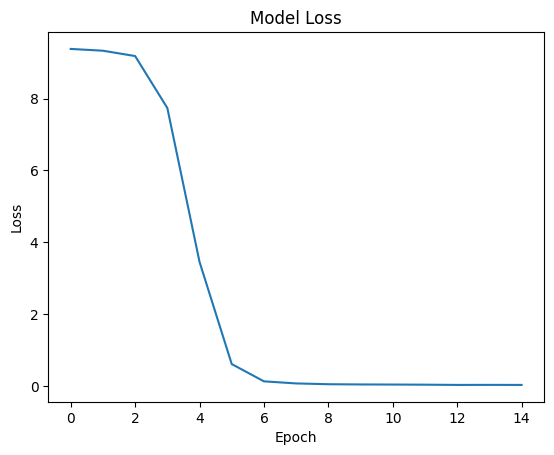

In [121]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


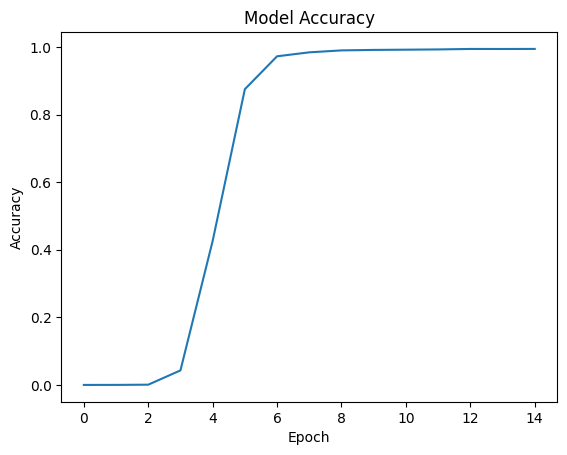

In [122]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [123]:
try_ingredients = ['bread', 'cheese']
try_ingredients_sequence = tokenizer.texts_to_sequences([try_ingredients])
try_ingredients_padded = pad_sequences(try_ingredients_sequence, maxlen=padded_sequences.shape[1])

predictions = model.predict(try_ingredients_padded)
predicted_recipe_id = label_encoder.inverse_transform([np.argmax(predictions)])

# Top 3 de recetas mas probables
top_3 = predictions.argsort()[0][-3:][::-1]
for i in top_3:
    recipe_id = label_encoder.inverse_transform([i])[0]
    recipe_name = recipes[recipes['id'] == recipe_id]['name'].values[0]
    probability = predictions[0][i]
    print(f'[{recipe_id}] {recipe_name}: {probability*100:.2f}%')

1/1 [==============================] - 0s 30ms/step
[9518] 30 second sandwich: 81.83%
[531520] cheeze bread: 7.68%
[416211] smoked fattie: 4.38%


## Modelo sin embedding

In [124]:
# Construccion del modelo
model = Sequential()
model.add(Dense(128, input_dim=ingredients_presence.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(recipes_q, activation='softmax'))

# Compilacion del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(ingredients_presence, one_hot_labels, epochs=15, verbose=1)

Epoch 1/15
350/350 [==============================] - 1s 4ms/step - loss: 9.3839 - accuracy: 0.0000e+00
Epoch 2/15
350/350 [==============================] - 1s 4ms/step - loss: 9.3191 - accuracy: 2.6807e-04
Epoch 3/15
350/350 [==============================] - 1s 3ms/step - loss: 8.3048 - accuracy: 0.0127
Epoch 4/15
350/350 [==============================] - 1s 3ms/step - loss: 5.1042 - accuracy: 0.2171
Epoch 5/15
350/350 [==============================] - 1s 3ms/step - loss: 1.8955 - accuracy: 0.6369
Epoch 6/15
350/350 [==============================] - 1s 3ms/step - loss: 0.4252 - accuracy: 0.9153
Epoch 7/15
350/350 [==============================] - 1s 4ms/step - loss: 0.1484 - accuracy: 0.9702
Epoch 8/15
350/350 [==============================] - 1s 4ms/step - loss: 0.0926 - accuracy: 0.9801
Epoch 9/15
350/350 [==============================] - 1s 4ms/step - loss: 0.0694 - accuracy: 0.9848
Epoch 10/15
350/350 [==============================] - 1s 4ms/step - loss: 0.0616 - accuracy

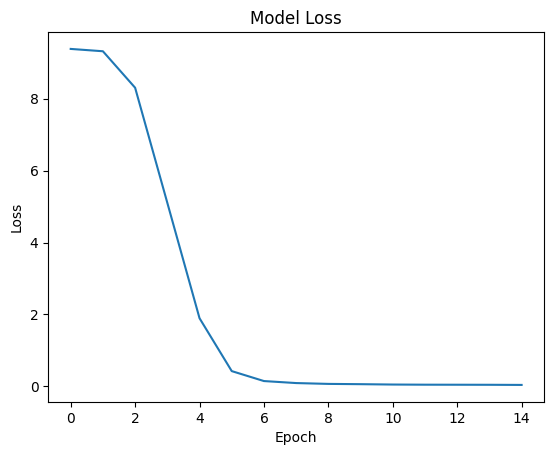

In [125]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


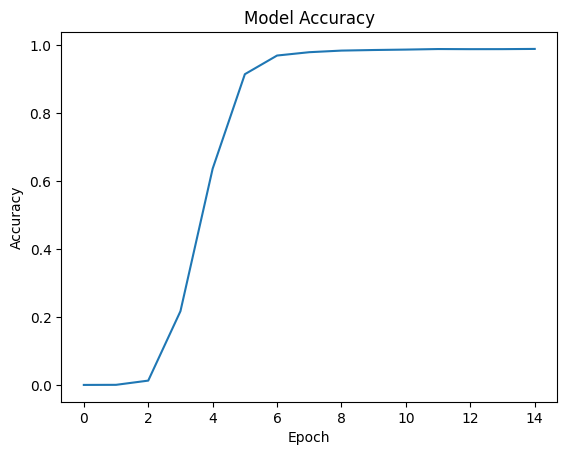

In [126]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [127]:
input_binary = mlb.transform([try_ingredients])

# Predicciones
predictions = model.predict(np.array(input_binary))[0]

# Top 3 de recetas mas probables
top_3 = predictions.argsort()[-3:][::-1]
for i in top_3:
    recipe_id = label_encoder.inverse_transform([i])[0]
    recipe_name = recipes[recipes['id'] == recipe_id]['name'].values[0]
    probability = predictions[i]
    print(f'[{recipe_id}] {recipe_name}: {probability*100:.2f}%')
    

1/1 [==============================] - 0s 30ms/step
[9518] 30 second sandwich: 84.42%
[531520] cheeze bread: 8.92%
[120887] breakfast sandwich: 1.54%
